In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [17]:
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("bioAI.mplstyle")
sys.path.append("../src") if "../src" not in sys.path else None 

from Experiment import Experiment
from methods import PCA_UMAP, multiimshow
from stats import grid_score_masks
from plotting_functions import *

import utils

In [3]:
# Load ratemaps and module indices
base_path = "/mnt/WD12TB-HDD"
experiment = utils.load_experiment(base_path, "gg-3ME")
ratemaps = utils.load_ratemaps(experiment)

# uninteresting clusters
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_uninteresting.npz")
print(module_indices.files)
clusters = [module_indices[f] for f in module_indices.files]

# ---> select cells by manifold (gardner et al.) <---
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_new.npz")
module_indices = module_indices['C0_from_env_2']

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.
['C1_from_env_0', 'C2_from_env_0', 'C6_from_env_0']


In [5]:
cluster_maps = np.reshape(ratemaps, (*ratemaps.shape[:2],-1)) # flatten bin dims; (Nenv, Ng, nbins)
cluster_maps = np.transpose(cluster_maps, (0, 2, 1)) # reshape so cell dim is last
nan_mask = ~np.isnan(ratemaps)
nan_mask = np.all(nan_mask, axis=1).reshape(3,-1)
num_environments = len(ratemaps)
cluster_maps = [cluster_maps[i, nan_mask[i]] for i in range(num_environments)] # mask out nan cells
cluster0_maps = [cluster_maps[i][:, clusters[0]] for i in range(num_environments)] # mask out torus units
cluster1_maps = [cluster_maps[i][:, clusters[1]] for i in range(num_environments)] # mask out torus units
cluster2_maps = [cluster_maps[i][:, clusters[2]] for i in range(num_environments)] # mask out torus units
print([c.shape for c in cluster0_maps], [c.shape for c in cluster1_maps], [c.shape for c in cluster2_maps])

[(4071, 256), (4049, 256), (4083, 256)] [(4071, 176), (4049, 176), (4083, 176)] [(4071, 194), (4049, 194), (4083, 194)]


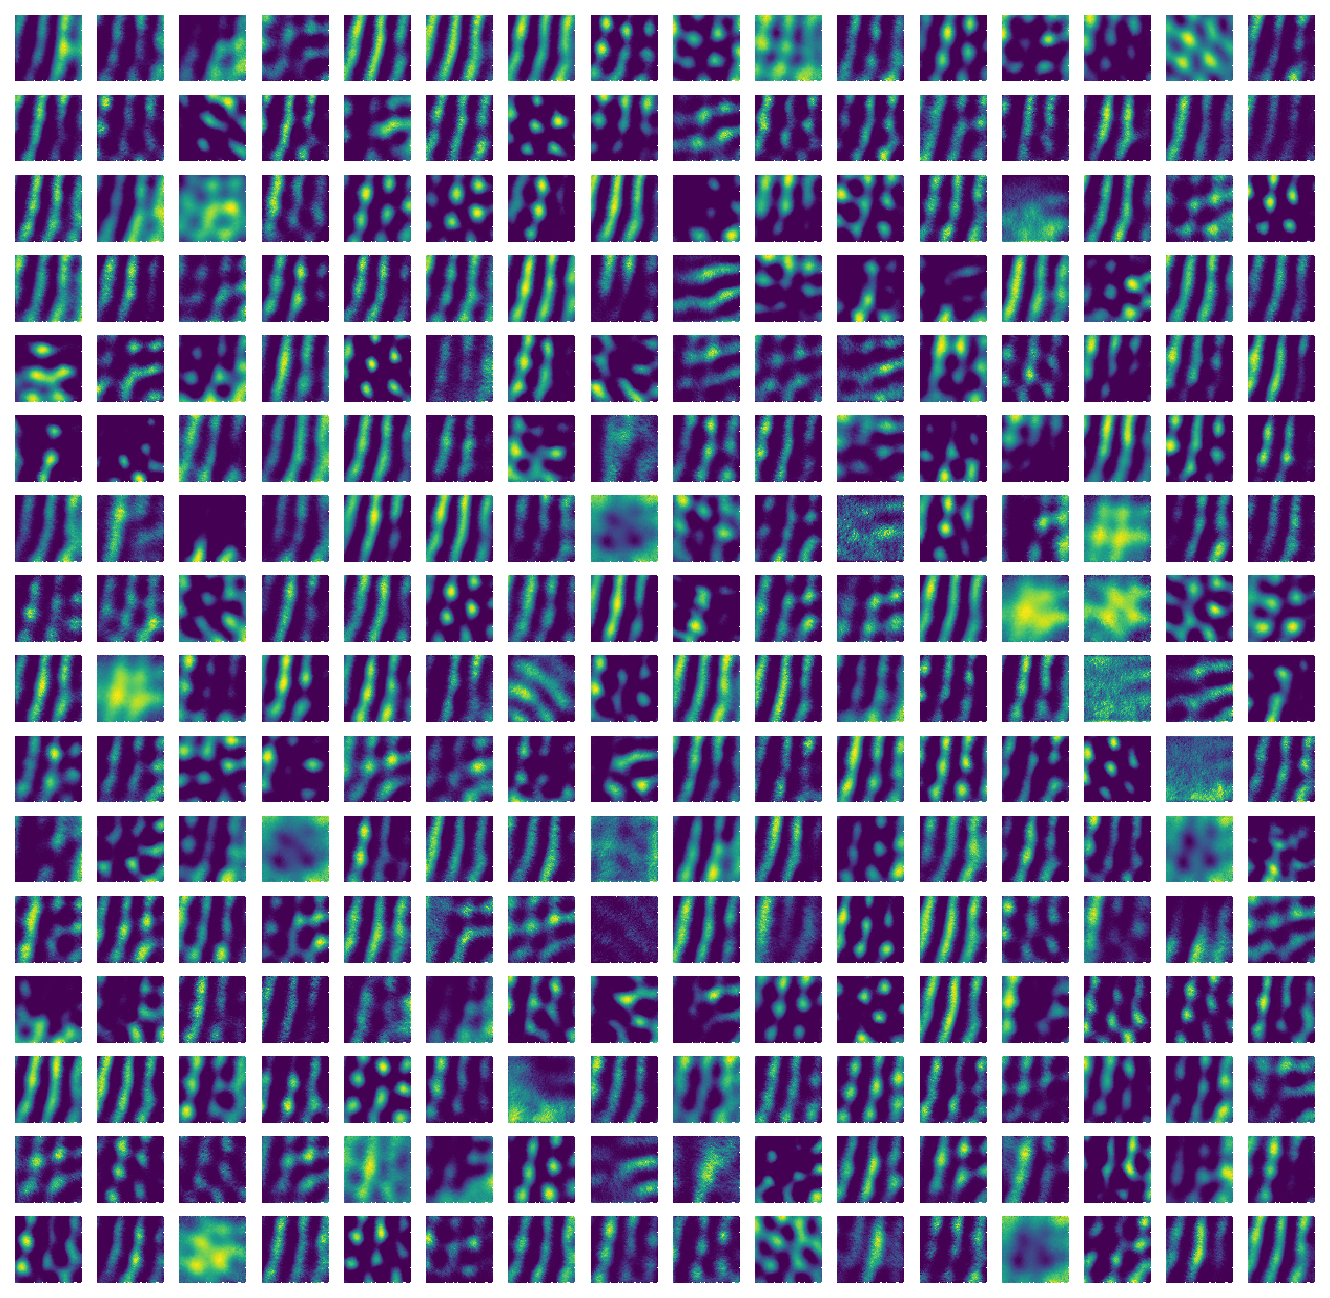

In [95]:
multiimshow(ratemaps[0][clusters[0]],normalize=False);

In [78]:
mean_fire = np.nanmean(ratemaps[1][clusters[0]],axis=(1,2))
mean_fire = np.argsort(mean_fire)[::-1]
baddies, goodies = mean_fire[:10], mean_fire[10:]


In [82]:
ratemaps.shape

(3, 4096, 64, 64)

In [91]:
g = cluster0_maps[0][:,goodies]
pca_fit, umap_fit = PCA_UMAP(g)

(<Figure size 1500x1500 with 4 Axes>,
 array([[<Axes3D: title={'center': 'azim=0.0, elev=0.0'}>,
         <Axes3D: title={'center': 'azim=90.0, elev=0.0'}>],
        [<Axes3D: title={'center': 'azim=0.0, elev=45.0'}>,
         <Axes3D: title={'center': 'azim=90.0, elev=45.0'}>]], dtype=object))

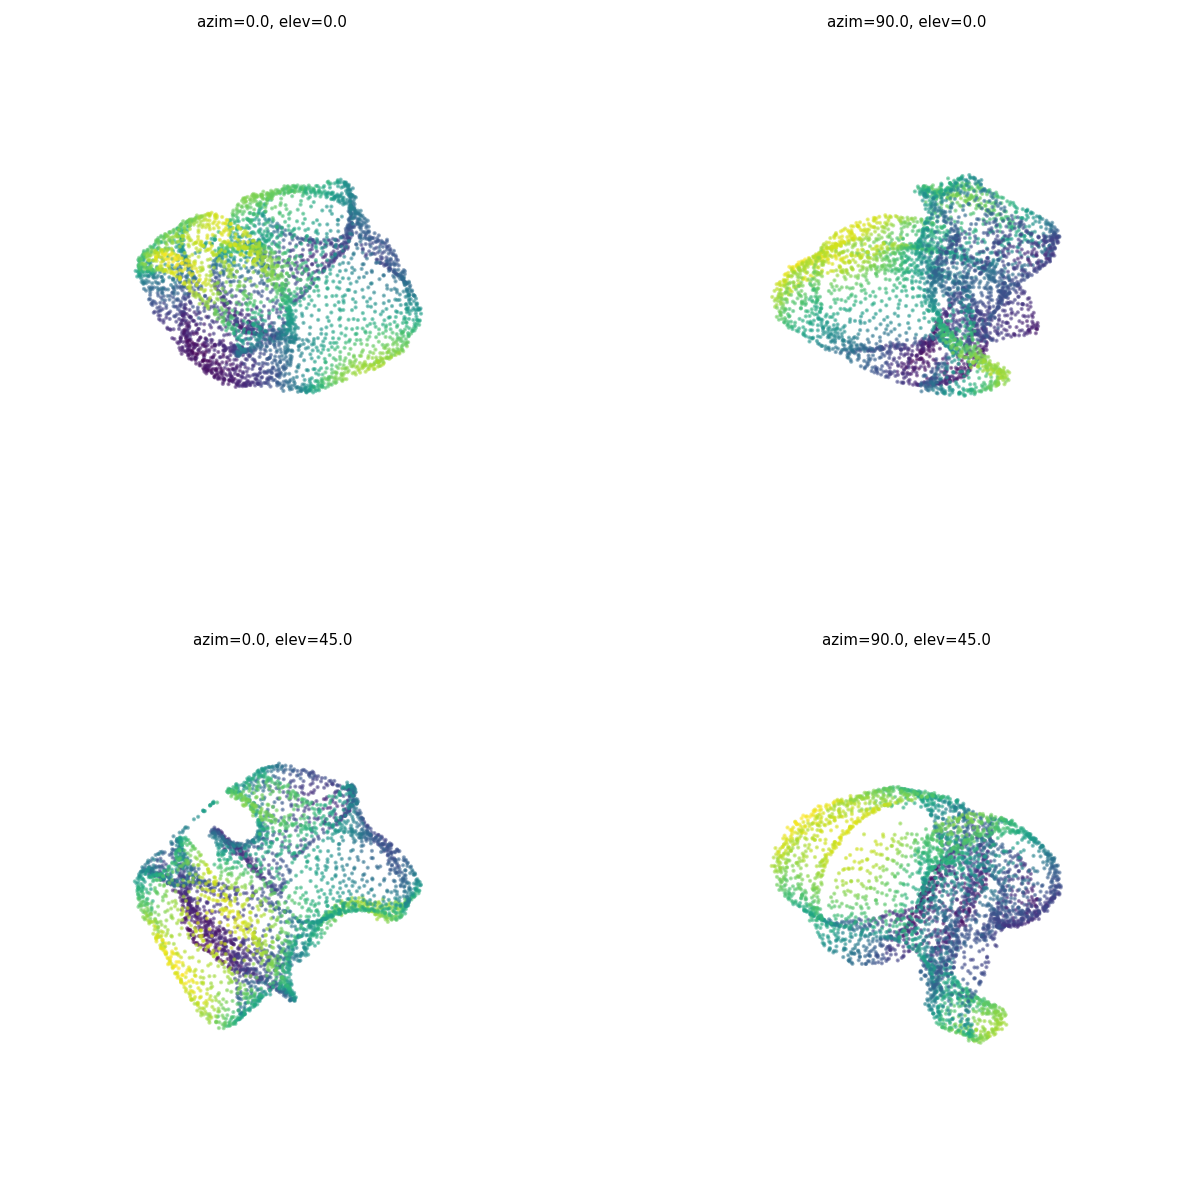

In [94]:
scatter3d(umap_fit, pca_fit[:,0], s=1, alpha=0.5, figsize=(10,10))

(<Figure size 1680x1680 with 256 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <

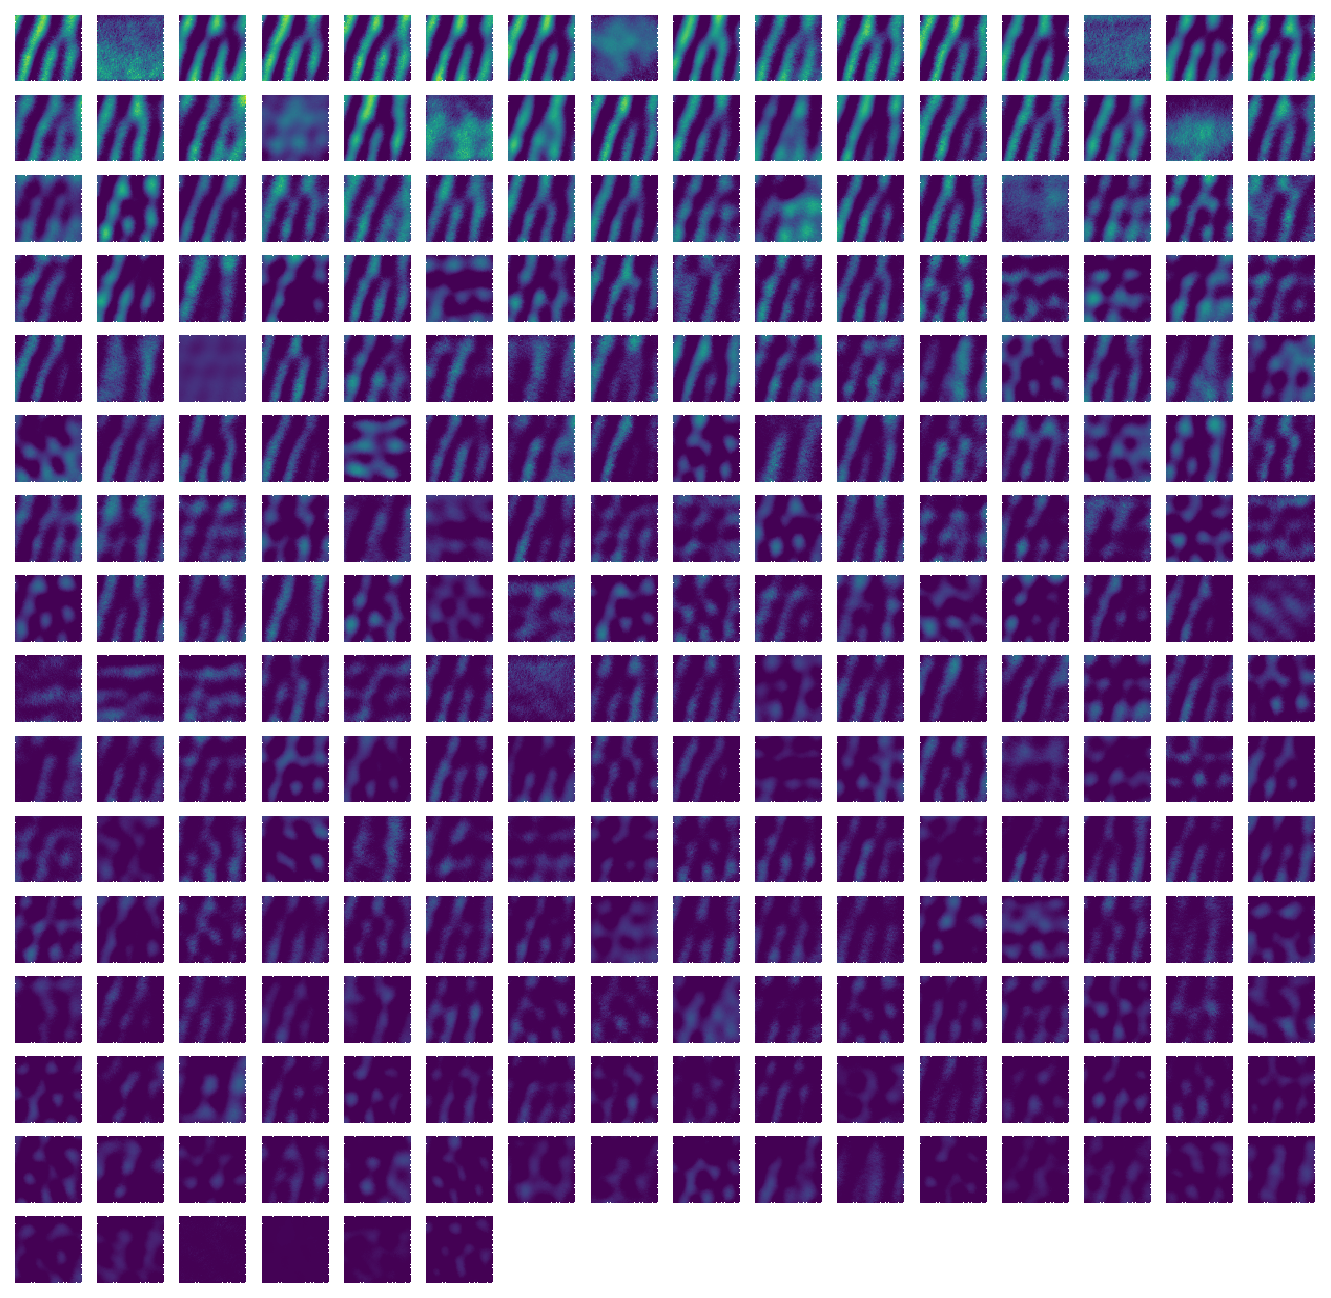

In [79]:
multiimshow(ratemaps[0][clusters[0][goodies]])

In [6]:
import tqdm
pca_fits = []
umap_fits = []
for cluster_map in [cluster0_maps, cluster1_maps, cluster2_maps]:
    pca_fits.append([])
    umap_fits.append([])
    for env_i in tqdm.trange(num_environments):
        pca_fit, umap_fit = PCA_UMAP(cluster_map[env_i])
        pca_fits[-1].append(pca_fit)
        umap_fits[-1].append(umap_fit)

100%|██████████| 3/3 [00:46<00:00, 15.66s/it]


0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


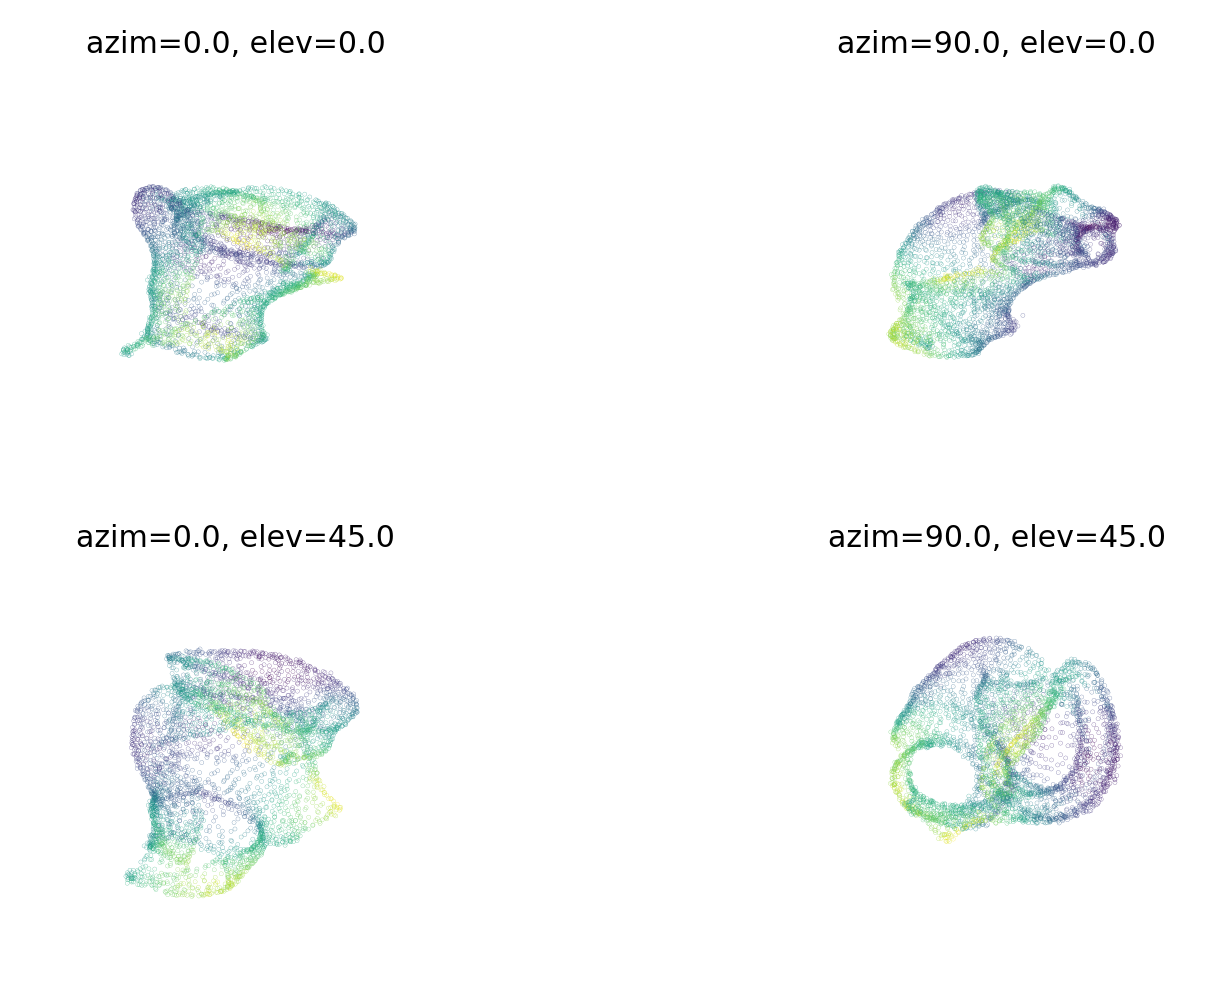

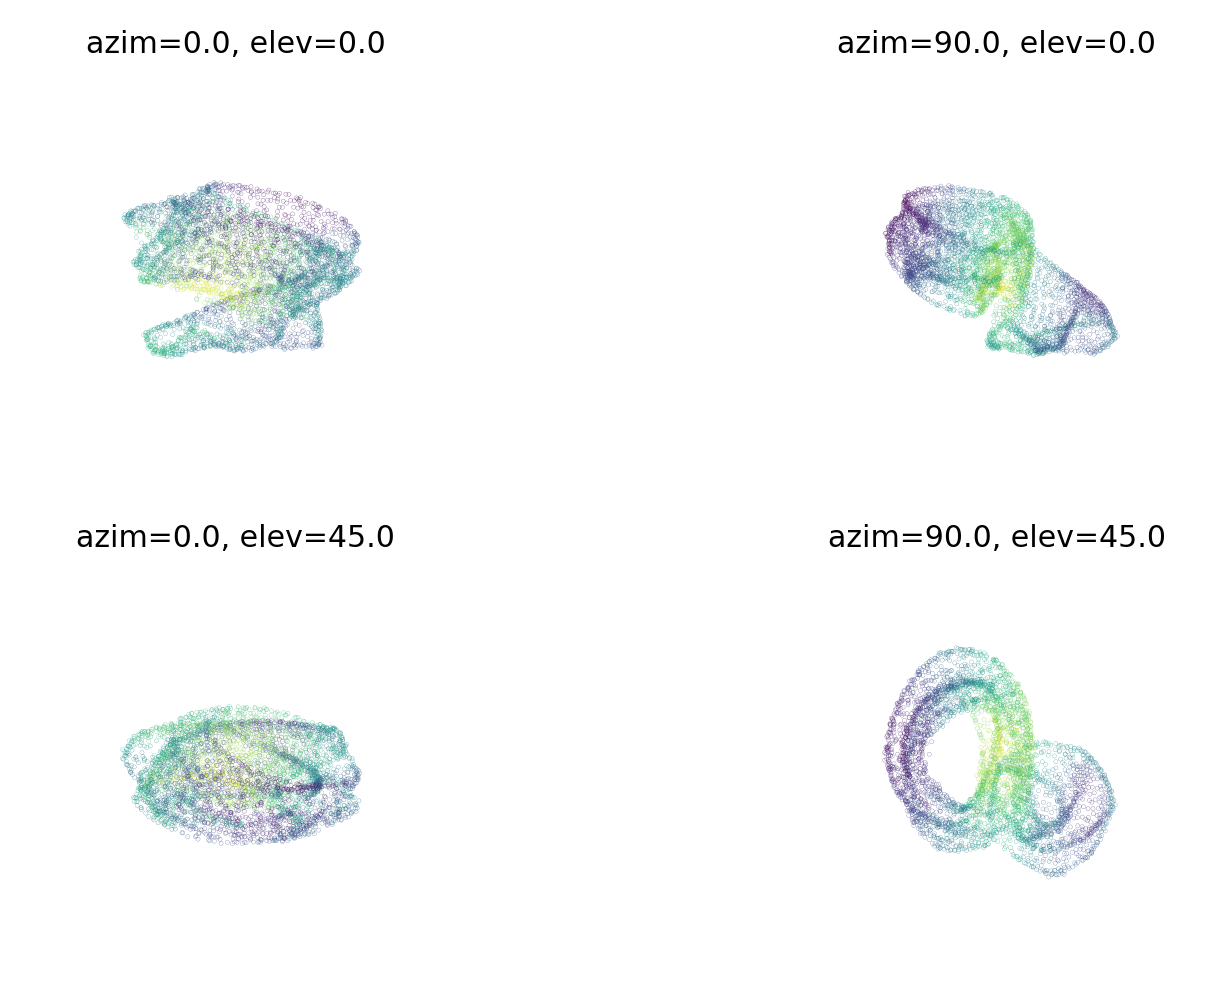

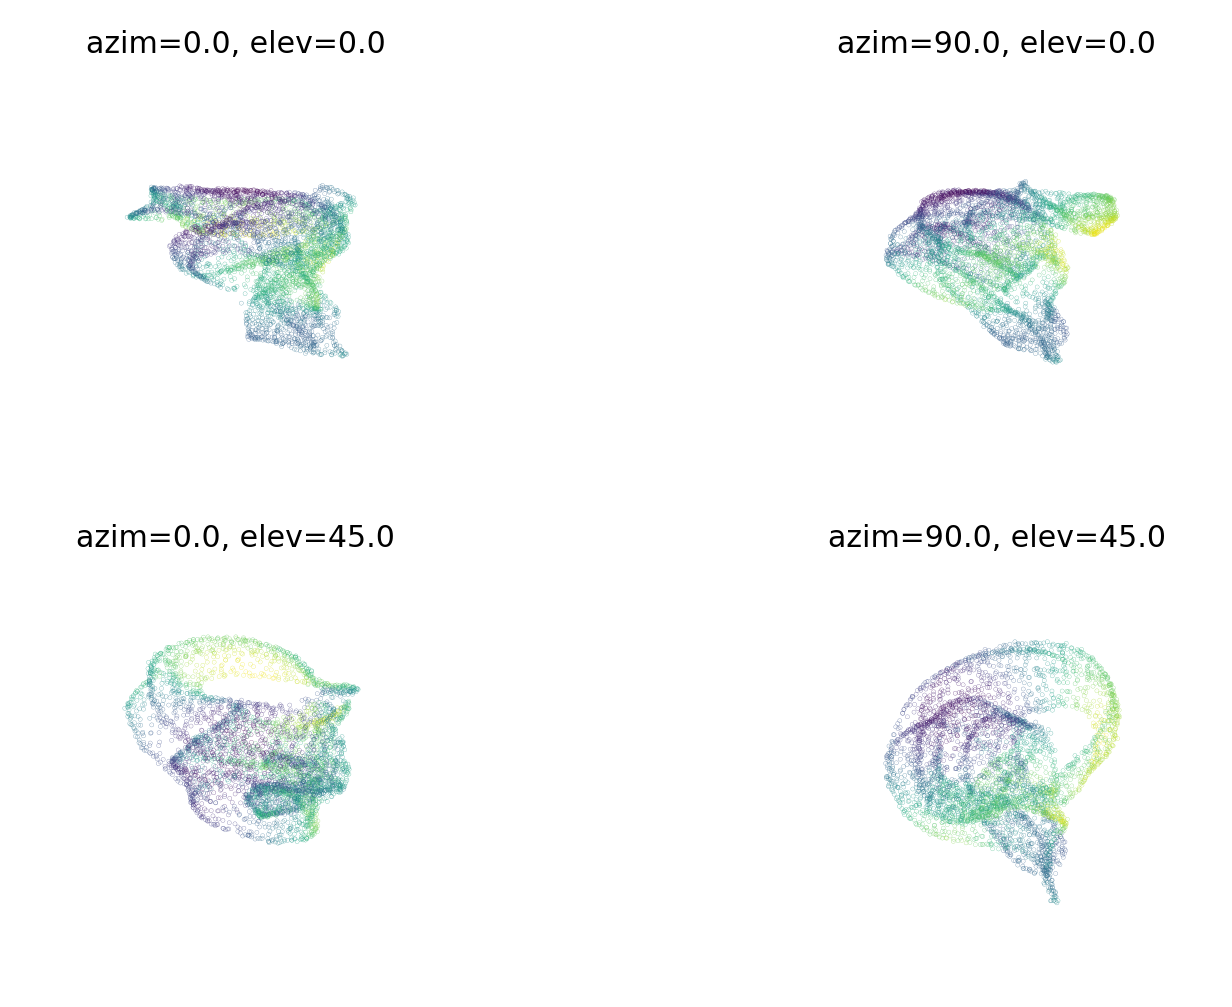

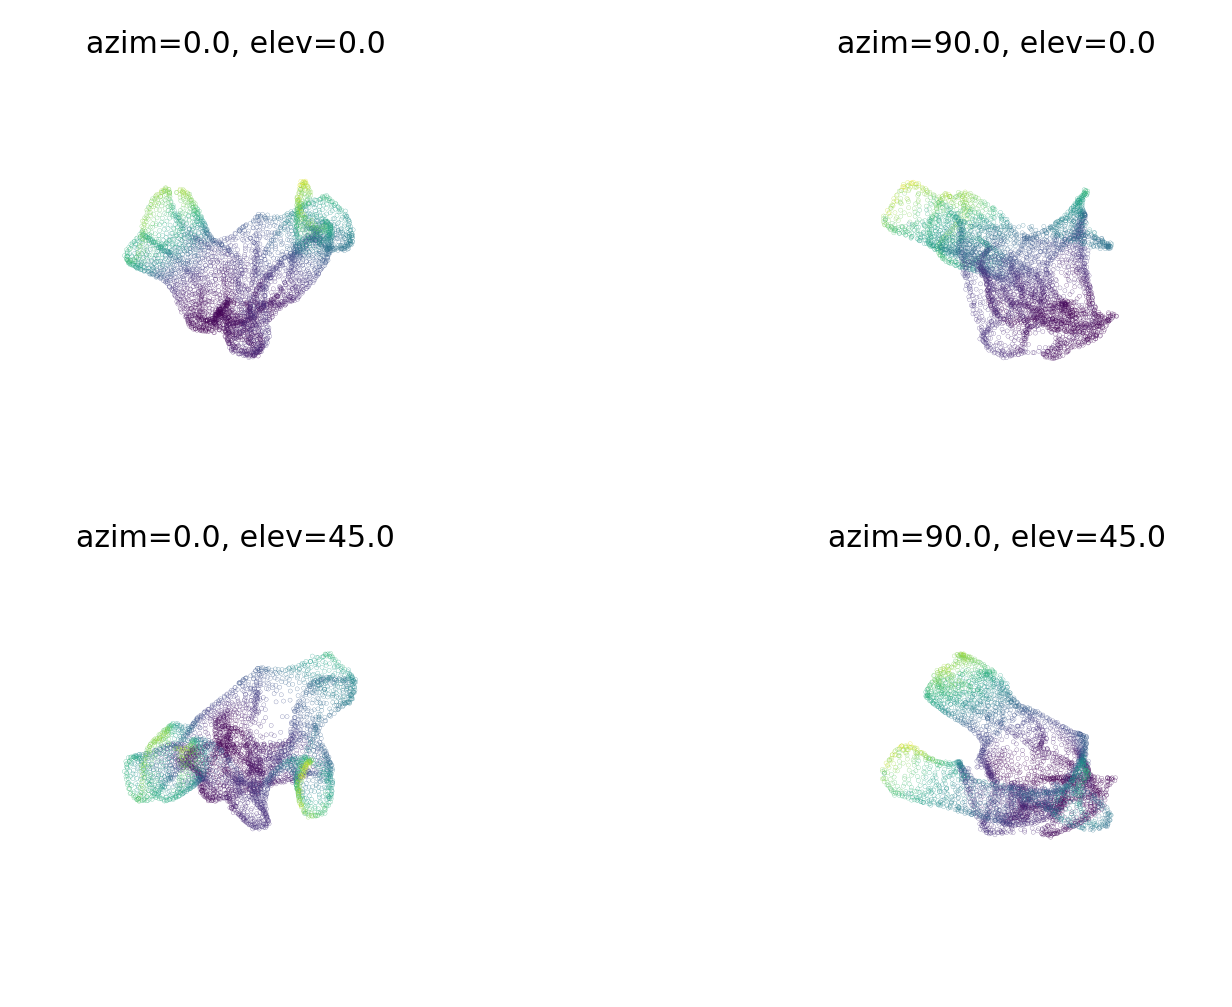

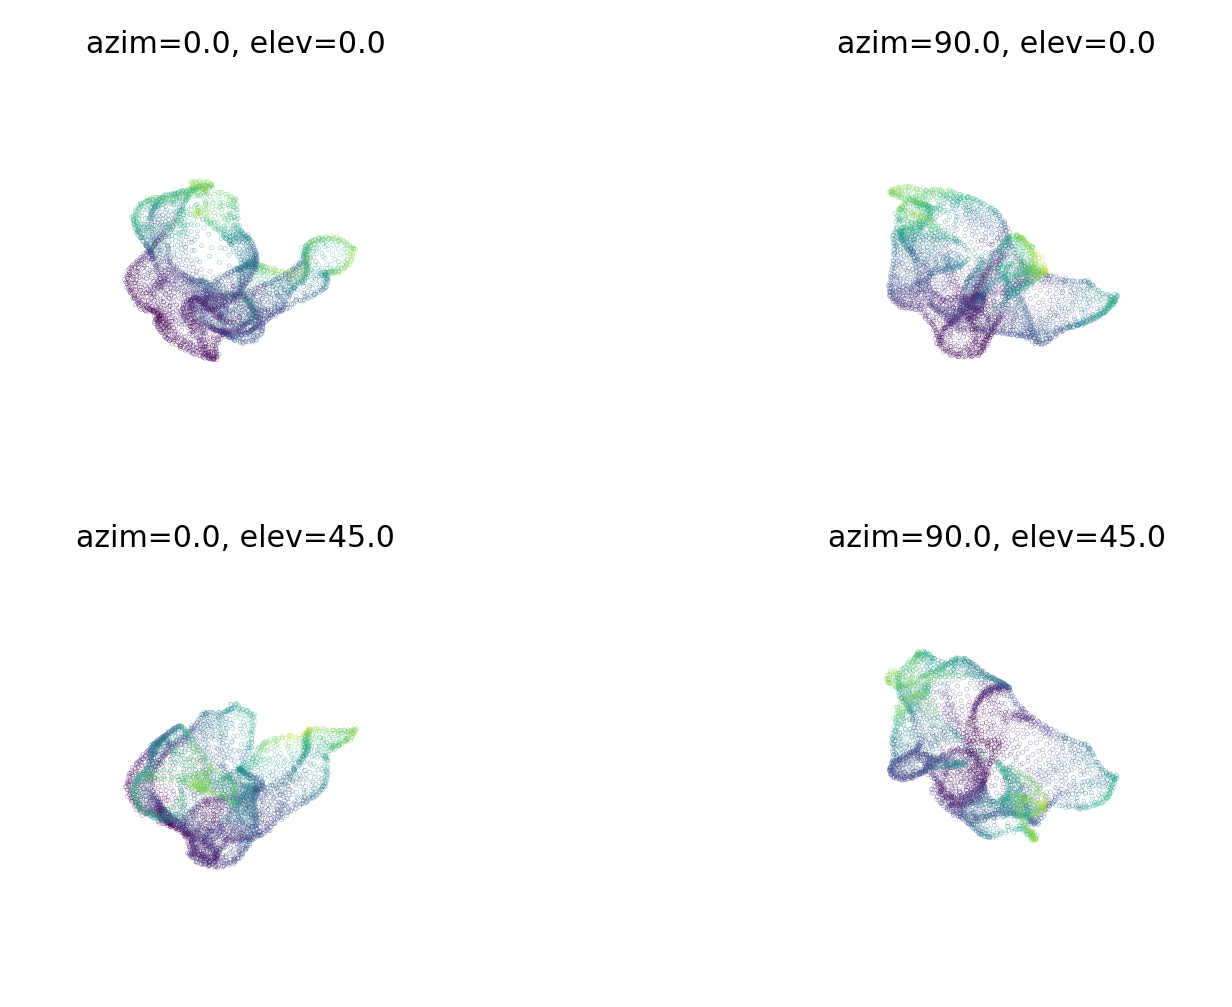

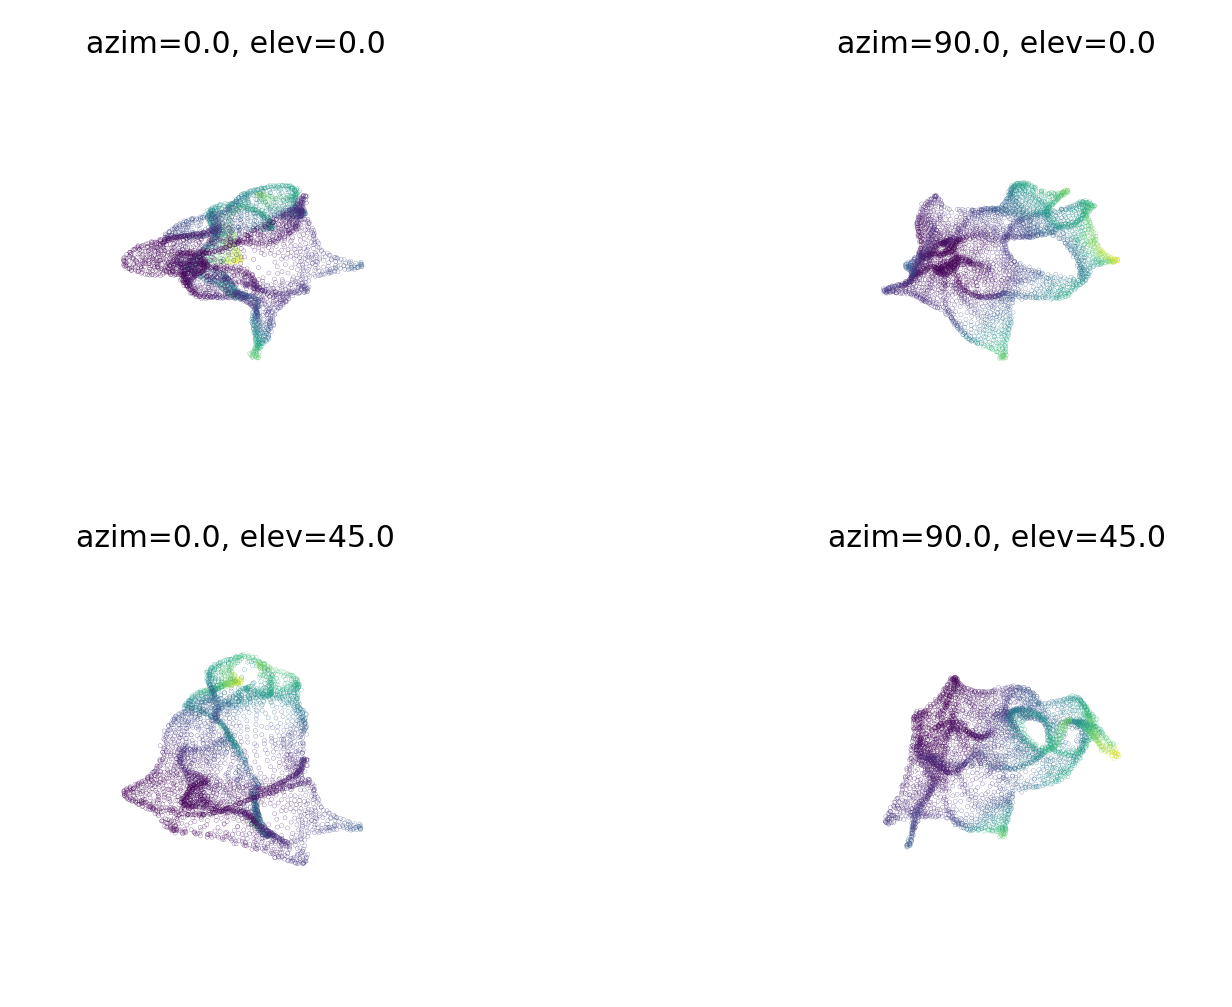

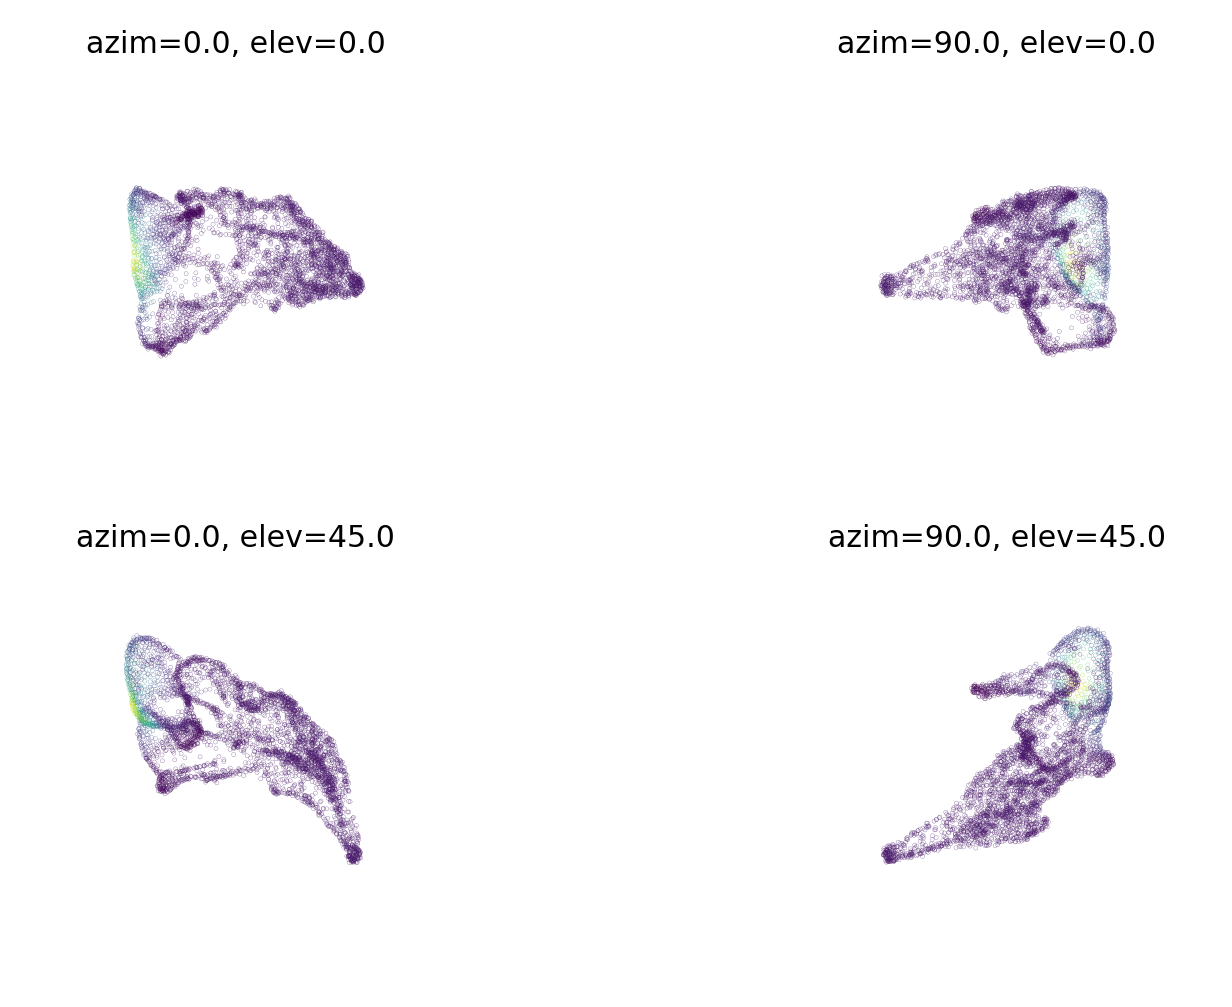

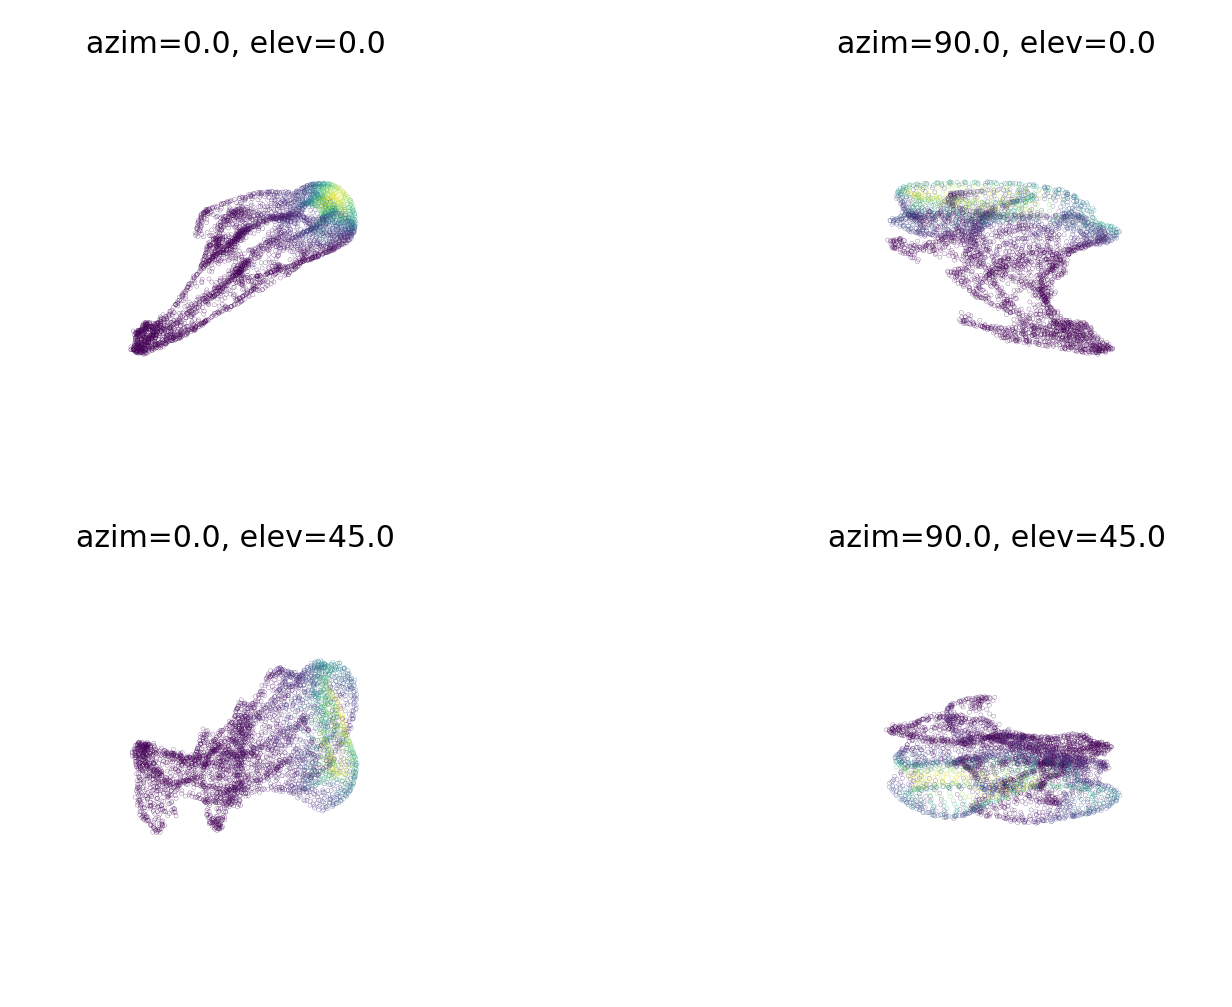

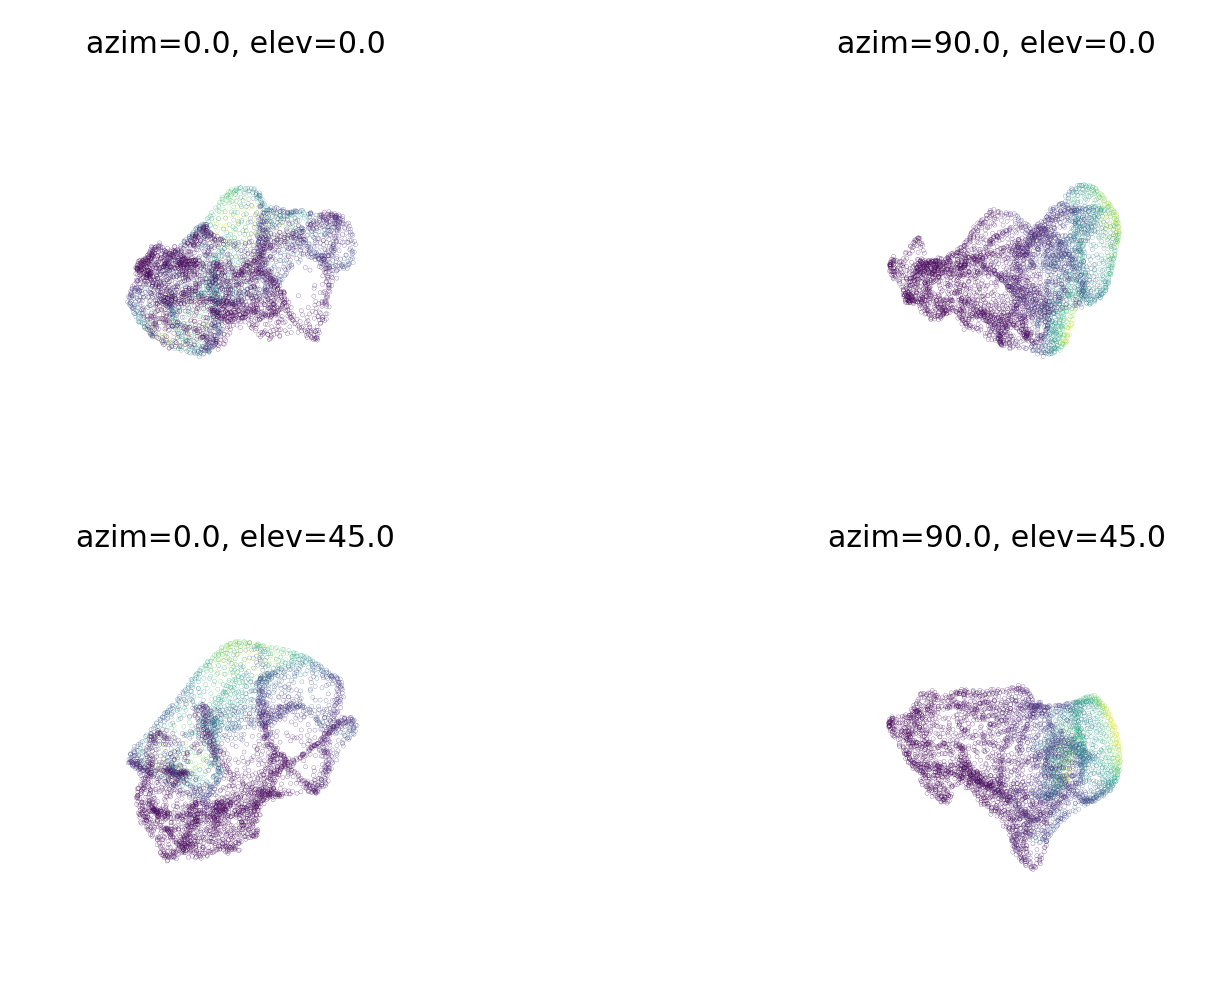

In [12]:
for cluster_i in range(3):
    for env_i in range(num_environments):
        print(cluster_i, env_i)
        fig, axs = scatter3d(umap_fits[cluster_i][env_i], pca_fits[cluster_i][env_i][:,0], s=0.005, alpha=0.8, dpi=300)
        #fig,axs = scatter3d(umap_fits[env_i],pca_fits[env_i][:,0],nrows=2,ncols=2,azim_elev_title=False,s=0.005,alpha=0.8,dpi=300)
        #fig.savefig(experiment.paths['experiment'] / f'plots/torei_{selection_process_name}_{env_i}')